In [22]:
# Node2Vec Model Using torch geometric with Cora
import torch
from torch_geometric.datasets import Planetoid
import os
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [ ]:
# DOWNLOAD DATA
#os.environ['http_proxy'] = "http://proxy-sifi.rd.corpintra.net:3128" 
#os.environ['https_proxy'] = "http://proxy-sifi.rd.corpintra.net:3128"
path = os.getcwd()
dataset = Planetoid(path, "Cora")

In [ ]:
# IMPORT DATA
data = dataset[0]
print('Coda: ', data)

In [ ]:
# CONSTRUCT THE MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Node2Vec_model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20, context_size=10,
                 walks_per_node=10, p=1, q=1, num_negative_samples=1,
                 num_nodes=None, sparse=True).to(device)

loader = Node2Vec_model.loader(batch_size=128, shuffle=True, num_workers=4) # for batch training
optimizer = torch.optim.SparseAdam(list(Node2Vec_model.parameters()), # list of parameters
                                    lr = 0.01 # learning rate
                                    )

In [ ]:
# PLOT 2D OF EMBEDDED REPRESENTATION (BEFORE TRAINING!)
@torch.no_grad() # deactivate autograd functionality
def plot_point(colors):
    Node2Vec_model.eval() # evalutae the model based on the trained parameters
    z = Node2Vec_model(torch.arange(data.num_nodes, device=device)) # embedding rep
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure()
    for i in range(dataset.num_classes):
        plt.scatter(z[y==i,0], z[y==i,1],s=20,color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
        '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
        '#ffd700'
    ]
plot_point(colors)


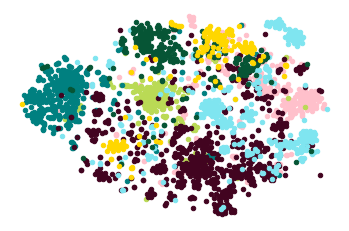

Epoch: 29, Loss: 0.8739


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


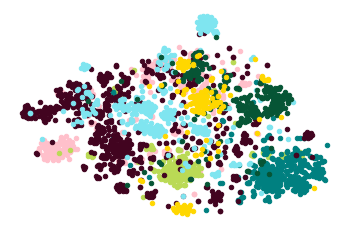

Epoch: 30, Loss: 0.8680


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


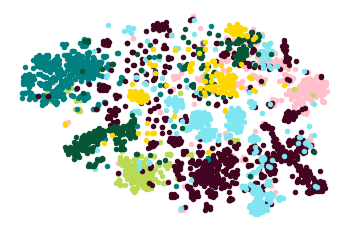

Epoch: 31, Loss: 0.8646


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


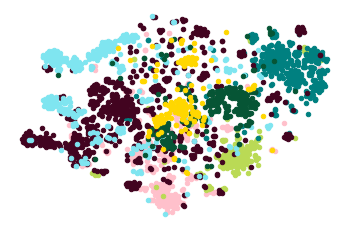

Epoch: 32, Loss: 0.8610


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


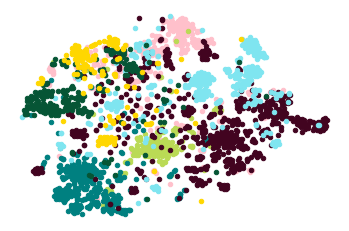

Epoch: 33, Loss: 0.8588


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


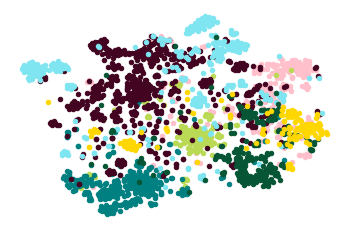

Epoch: 34, Loss: 0.8546


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


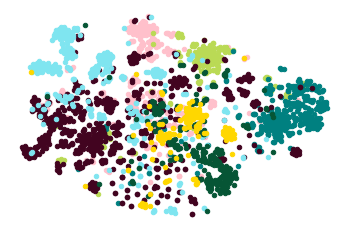

Epoch: 35, Loss: 0.8520


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


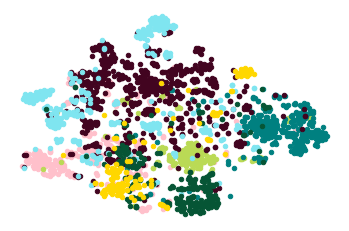

Epoch: 36, Loss: 0.8503


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


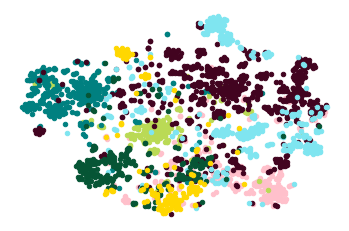

Epoch: 37, Loss: 0.8477


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


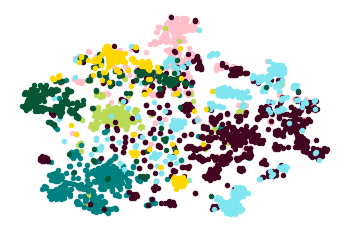

Epoch: 38, Loss: 0.8467


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


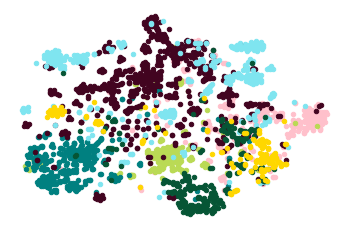

Epoch: 39, Loss: 0.8446


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


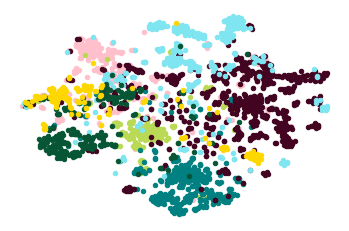

Epoch: 40, Loss: 0.8430


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


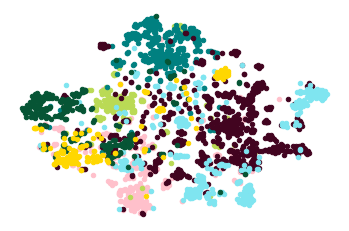

Epoch: 41, Loss: 0.8420


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


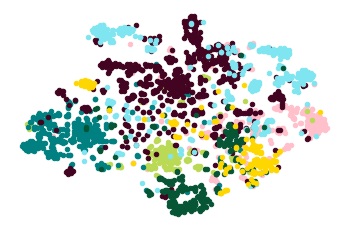

Epoch: 42, Loss: 0.8403


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


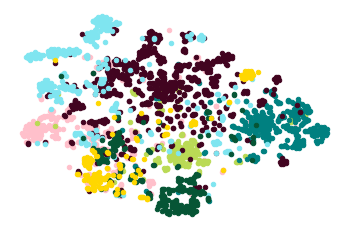

Epoch: 43, Loss: 0.8394


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


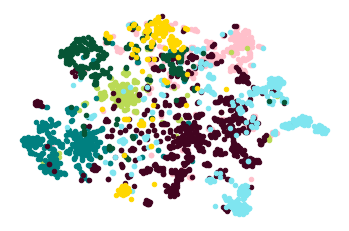

Epoch: 44, Loss: 0.8379


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


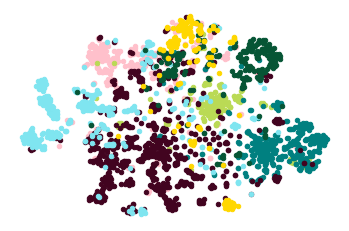

Epoch: 45, Loss: 0.8369


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# TRAIN FUNCTION
def train():
    Node2Vec_model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = Node2Vec_model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)
    
# OBTAIN EMBEDDING REPRESENTATION
for epoch in range(1,101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

In [ ]:
# PLOT 2D OF EMBEDDED REPRESENTATION
plot_point(colors)



In [ ]:
# NODE CLASSIFICATION
def test():
    Node2Vec_model.eval() # Evaluate the model based on the trained parameters
    z = Node2Vec_model() # evaluate the model based on the trained parameters
    acc = Node2Vec_model.test(  z[data.train_mask], data.y[data.train_mask],
                                z[data.test_mask], data.y[data.test_mask],
                                max_iter=150)
    return acc

print('Accuracy: ', test())
